## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("Mall_Customers.csv")

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
 df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## Exploratory Data Analysis

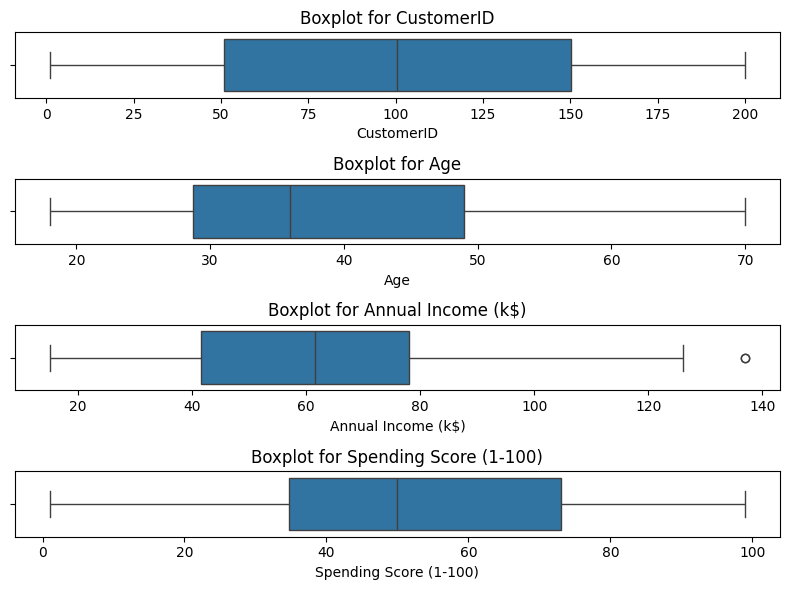

In [7]:
num_columns = df.select_dtypes(include=['number']).columns
num_plots = len(num_columns)

fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(8, 6))

for i, column in enumerate(num_columns):

    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

plt.tight_layout()
plt.show()

## Gender Distribution

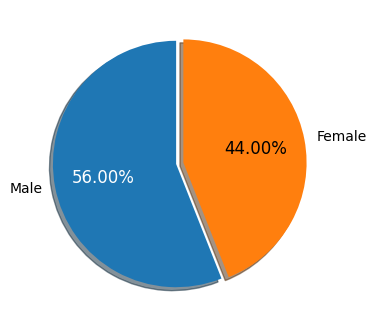

In [8]:
values = df['Gender'].value_counts()
labels = ['Male', 'Female']

fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
explode = (0, 0.06)

patches, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.2f%%', shadow=True,
                                   startangle=90, explode=explode)

plt.setp(texts, color='black')
plt.setp(autotexts, size=12, color='white')
autotexts[1].set_color('black')
plt.show()

## Pre processing

In [9]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

In [10]:
scaler = StandardScaler()

In [11]:
X_scaled = scaler.fit_transform(X)

In [12]:
X_scaled_df = pd.DataFrame(X_scaled, columns=['Annual Income (scaled)', 'Spending Score (scaled)'])

In [13]:
X_scaled_df.head()

,Annual Income (scaled),Spending Score (scaled)
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


##  Data Visualization 

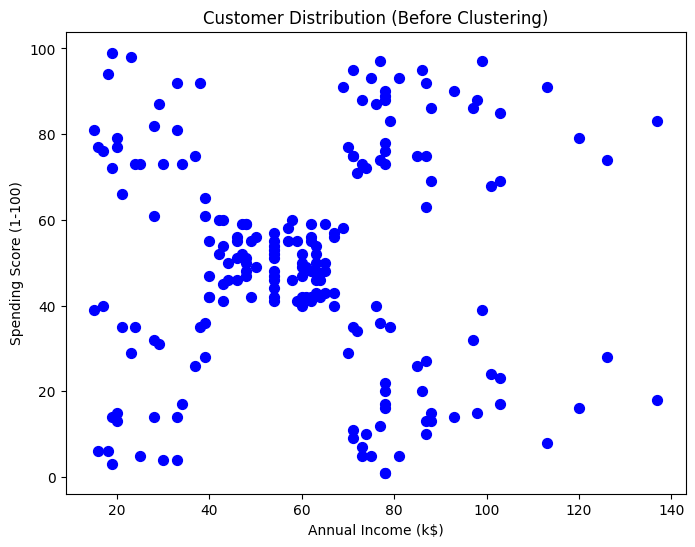

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c='blue', s=50)
plt.title("Customer Distribution (Before Clustering)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

 ## K-Means 

In [15]:
X_scaled = X_scaled_df.values

In [16]:
inertia = []
silhouette = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

## inertia (Elbow) + silhouette

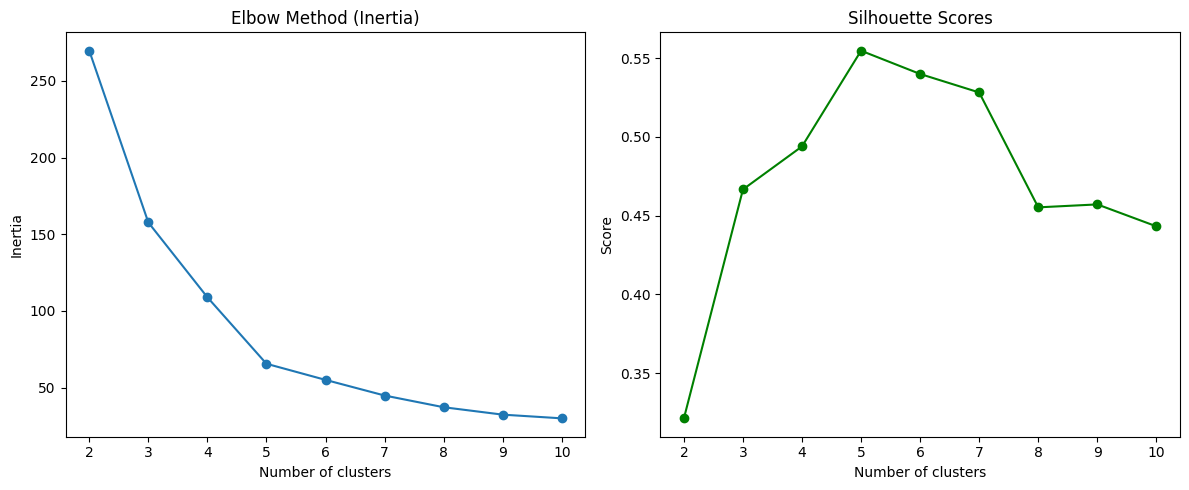

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, silhouette, marker='o', color='green')
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

## KMeans final with k=5 clusters

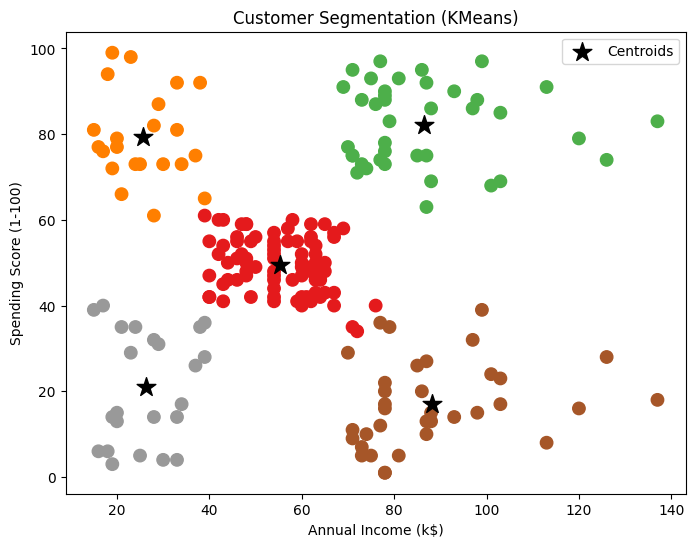

In [18]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'],
            c=df['Cluster'], cmap='Set1', s=80)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1],
            c='black', marker='*', s=200, label='Centroids')

plt.title("Customer Segmentation (KMeans)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.show()

## Density-Based Spatial Clustering of Applications with Noise clustering

In [19]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)

print("DBSCAN Cluster Labels:\n", df['Cluster_DBSCAN'].value_counts())

DBSCAN Cluster Labels:
 Cluster_DBSCAN
 0    157
 1     35
-1      8
Name: count, dtype: int64


## Average income & spending per cluster

In [20]:
avg_spending = df.groupby('Cluster')['Spending Score (1-100)'].mean()
print("Average Spending per KMeans Cluster:\n", avg_spending)

Average Spending per KMeans Cluster:
 Cluster
0    49.518519
1    82.128205
2    79.363636
3    17.114286
4    20.913043
Name: Spending Score (1-100), dtype: float64


In [21]:
avg_income = df.groupby('Cluster')['Annual Income (k$)'].mean()
print("Average Income per KMeans Cluster:\n", avg_income)


Average Income per KMeans Cluster:
 Cluster
0    55.296296
1    86.538462
2    25.727273
3    88.200000
4    26.304348
Name: Annual Income (k$), dtype: float64
